# Import Libraries

In [1]:
import os
import cv2
import numpy as np
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.preprocessing import normalize
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot as plt


# Load Data set

In [2]:
train_dir = 'objects_dataset/train/'
test_dir = 'objects_dataset/test/'

train_images = []
train_labels = []

test_images = []
test_labels = []

classes = os.listdir(train_dir)

In [3]:
for label in classes:
    for img_file in os.listdir(train_dir + label):
        img = cv2.imread(os.path.join(train_dir, label, img_file))
        train_images.append(img)
        train_labels.append(label)

In [4]:
for label in classes:
    for img_file in os.listdir(test_dir + label):
        img = cv2.imread(os.path.join(test_dir, label, img_file))
        test_images.append(img)
        test_labels.append(label)

# Extract SIFT Features

In [5]:
sift = cv2.xfeatures2d.SIFT_create()

In [6]:
train_descriptors = []
for img in train_images:
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    keypoints, descriptors = sift.detectAndCompute(gray, None)
    train_descriptors.append(descriptors)
np.vstack(train_descriptors).shape

(25089, 128)

In [7]:
test_descriptors = []
for img in test_images:
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    keypoints, descriptors = sift.detectAndCompute(gray, None)
    test_descriptors.append(descriptors)

# Make Visual Vocabulary

In [8]:
# Cluster SIFT descriptors into visual words
kmeans = KMeans(n_clusters=30)  # Adjust the number of visual words as needed
kmeans.fit(np.vstack(train_descriptors))

D:\Anaconda\envs\NUST\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=30)

In [9]:
# Generate histograms for each image using the visual words
train_histograms = []
for descriptors in train_descriptors:
    visual_words = kmeans.predict(descriptors)
    histogram, _ = np.histogram(visual_words, bins=np.arange(101))
    train_histograms.append(normalize(histogram.reshape(1, -1)))

In [10]:
test_histograms = []
for descriptors in test_descriptors:
    visual_words = kmeans.predict(descriptors)
    histogram, _ = np.histogram(visual_words, bins=np.arange(101))
    test_histograms.append(normalize(histogram.reshape(1, -1)))

# Random Forest Classifier

In [11]:
# Train Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(np.vstack(train_histograms), train_labels)


# Predict using Random Forest model
rf_predictions = rf.predict(np.vstack(test_histograms))
rf_accuracy = accuracy_score(test_labels, rf_predictions)
print("Random Forest Accuracy:", rf_accuracy)


rf_f1 = f1_score(test_labels, rf_predictions, average='weighted')
print("Weighted Random Forest F-1 Score:", rf_f1)

Random Forest Accuracy: 1.0
Weighted Random Forest F-1 Score: 1.0


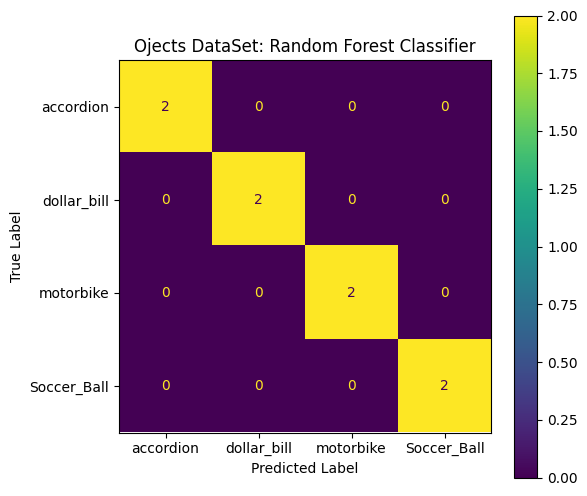

In [12]:
fig,ax = plt.subplots(figsize = (6,6))

# Create confusion matrix
cm_rf = confusion_matrix(test_labels, rf_predictions)
cm_display_rf = ConfusionMatrixDisplay(confusion_matrix = cm_rf, display_labels = classes)

cm_display_rf.plot(ax=ax)
plt.title("Ojects DataSet: Random Forest Classifier")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [13]:
FP_rf = cm_rf.sum(axis = 0) - np.diag(cm_rf)
FN_rf = cm_rf.sum(axis = 1) - np.diag(cm_rf)
TP_rf = np.diag(cm_rf)
TN_rf = cm_rf.sum() - (FP_rf + FN_rf + TP_rf)

print('Random Forest False Positive:',FP_rf)
print('Random Forest False Negative:',FN_rf)
print('Random Forest True Positive:',TP_rf)
print('Random Forest True Negative:',TN_rf)

Random Forest False Positive: [0 0 0 0]
Random Forest False Negative: [0 0 0 0]
Random Forest True Positive: [2 2 2 2]
Random Forest True Negative: [6 6 6 6]


In [14]:
TPR_rf = TP_rf/(FN_rf + TP_rf)
FPR_rf = FP_rf/ (FN_rf + TP_rf)
print('Random Forest False Positive Rate:',FPR_rf)
print('Random Forest True Positive Rate:',TPR_rf)

Random Forest False Positive Rate: [0. 0. 0. 0.]
Random Forest True Positive Rate: [1. 1. 1. 1.]


# SVM Classifier

In [15]:
# Train SVM model
svm = SVC(kernel='linear')
svm.fit(np.vstack(train_histograms), train_labels)


# Predict using SVM model
svm_predictions = svm.predict(np.vstack(test_histograms))
svm_accuracy = accuracy_score(test_labels, svm_predictions)
svm_f1 = f1_score(test_labels, svm_predictions, average='weighted')
print("SVM Accuracy:", svm_accuracy)
print("Weighted SVM F-1 Score:", svm_f1)

SVM Accuracy: 0.875
Weighted SVM F-1 Score: 0.8666666666666667


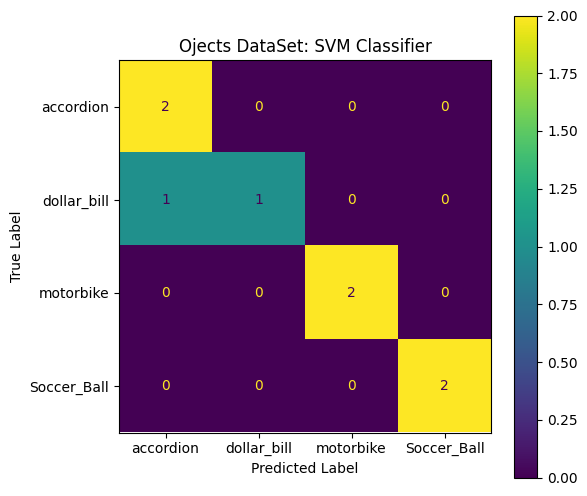

In [16]:
fig,ax = plt.subplots(figsize = (6,6))

# Create confusion matrix
cm = confusion_matrix(test_labels, svm_predictions)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = classes)

cm_display.plot(ax=ax)
plt.title("Ojects DataSet: SVM Classifier")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [17]:
FP = cm.sum(axis = 0) - np.diag(cm)
FN = cm.sum(axis = 1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

print('SVM False Positive:',FP)
print('SVM False Negative:',FN)
print('SVM True Positive:',TP)
print('SVM True Negative:',TN)

SVM False Positive: [1 0 0 0]
SVM False Negative: [0 1 0 0]
SVM True Positive: [2 1 2 2]
SVM True Negative: [5 6 6 6]


In [18]:
TPR = TP/(FN + TP)
FPR = FP/ (FN + TP)
print('SVM False Positive Rate:',FPR)
print('SVM True Positive Rate:',TPR)

SVM False Positive Rate: [0.5 0.  0.  0. ]
SVM True Positive Rate: [1.  0.5 1.  1. ]
